In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

https://github.com/mcsiple/tidytuesday/blob/master/2021/5_2021_plastics.R

https://raw.githubusercontent.com/mcsiple/tidytuesday/master/2021/5_2021_plastics.png

https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-01-26/readme.md

In [2]:
path = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-26/plastics.csv"
data = pd.read_csv(path)

In [3]:
types_of_plastic = ["empty", "hdpe", "ldpe", "o", "pet", "pp", "ps", "pvc"]
total_by_company = (
    data
    .groupby(["parent_company", "year"], dropna=True)[types_of_plastic]
    .sum()
    .reset_index()
)
total_by_company

,parent_company,year,empty,hdpe,ldpe,o,pet,pp,ps,pvc
0,"""ESE""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Inko"" noodles / Ð®Ñ„ÐºÐ° â€œÐ˜Ð½ÐºÐ¾""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Мелочи Жизни"" (Ооо Ергопак)",2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,#ERROR!,2020,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4,(Local Factory),2020,0.0,0.0,0.0,0.0,9.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11215,Ямуна,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
11216,Янтар,2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11217,Янтар (Сан Інбев Україна),2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11218,Янтарь,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
def get_top_n_data(data, n):
    """Create data frame with plastic values for the top-n companies and one Others group."""

    # Analyses data from 2020 only
    # Compute the total plastic waste per company
    top_data = (
        data
        .query("year == 2020")
        .melt(
            id_vars=["parent_company", "year"], 
            value_vars=types_of_plastic, 
            var_name="type"
        )
        .groupby("parent_company")["value"]
        .sum()
        .reset_index()
    )

    # Use "Unbranded_unknown" for unbranded/unknown/error cases
    top_data["parent_company"] = np.where(
        top_data["parent_company"].isin(["Unbranded", "null", "NULL", "#ERROR!"]), 
        "Unbranded_unknown",
        top_data["parent_company"]
    )

    # Create a list of top companies.
    # This list contains the top n companies with largest plastic waste.
    top_companies = list(top_data.sort_values("value", ascending=False)["parent_company"][:n])

    # Create a lumped version of the company variable. 
    # If "parent_company" is one of the top companies, it gets its original name. 
    # Otherwise, it's labelled with "Other"
    top_data["company_lumped"] = np.where(
        top_data["parent_company"].isin(top_companies),
        top_data["parent_company"],
        "Other"
    )

    # Merge `top_data` with `total_by_company`
    top_data = top_data.drop_duplicates(["parent_company", "company_lumped"])
    top_data = top_data.merge(total_by_company, on="parent_company")

    # Sum all types of plastic except from 'empty' into the "total" variable
    top_data["total"] = top_data.loc[:, types_of_plastic[1:]].sum(axis=1)

    return top_data

## Heatmap

In [5]:
top_thirty = get_top_n_data(total_by_company, n=30)

# For each company, compute the total waste per each type of plastic
top_thirty = (
    top_thirty
    .groupby("company_lumped")[types_of_plastic]
    .sum()
    .reset_index()
)

# Add a column with the sum of the plastic waste for all types of plastic
top_thirty["row_sum"] = top_thirty.loc[:, types_of_plastic].sum(axis=1)

# Divide the waste of each type of plastic by the total waste to get the proportion of waste for
# each type of plastic
top_thirty[types_of_plastic] = top_thirty[types_of_plastic].apply(lambda x: x / top_thirty["row_sum"])

# Unpivot data
top_thirty = top_thirty.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="proportion"
)

top_thirty

,company_lumped,type,proportion
0,Bakhresa Group,empty,0.000000
1,Blow-Chem Industries,empty,0.000000
2,Britannia,empty,0.000000
3,Colgate-Palmolive,empty,0.000611
4,Cway Group,empty,0.000000
...,...,...,...
235,Unilever,pvc,0.002212
236,Universal Robina Corporation,pvc,0.005780
237,Voltic Ghana Limited,pvc,0.000000
238,W.L. Food Products,pvc,0.000000


Let's ensure company names are sorted appropriately. Company names are sorted alphabetically, except from `"Others"` which goes in the last place.

In [6]:
# Get company names
categories = list(top_thirty["company_lumped"].unique())
# Sort categories according to their lowercase version (this step is important!)
sorted_categories = sorted(categories, key=str.lower)
# Remove "Other" from the list and append it to the taiL
sorted_categories.remove("Other")
sorted_categories.append("Other")

Now use these categories to convert the `"company_lumped"` variable into an ordered categorical variable.

In [7]:
top_thirty["company_lumped"] = pd.Categorical(
    top_thirty["company_lumped"], 
    categories=sorted_categories, 
    ordered=True
)

# Finally, sort the values in the data frame according to this custom sort.
top_thirty = top_thirty.sort_values("company_lumped", ascending=False)

Let's create the colormap for the heatmap. 

In [8]:
# Colormap
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)

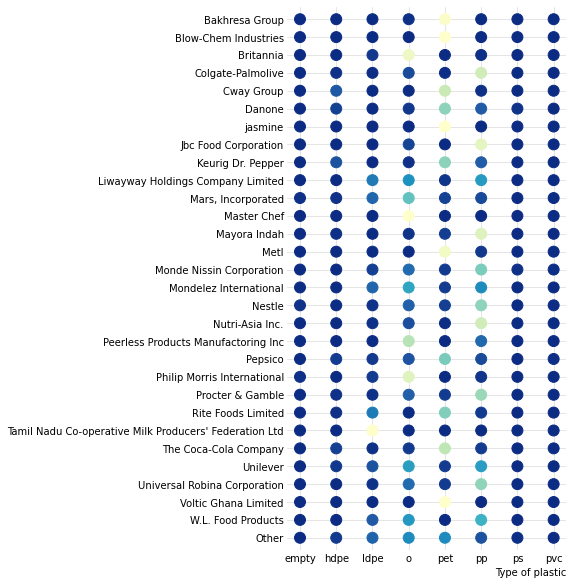

In [9]:
fig, ax = plt.subplots(figsize=(5, 10))

for i, plastic in enumerate(types_of_plastic):
    d = top_thirty[top_thirty["type"] == plastic]
    y = d["company_lumped"]
    x = [i] * len(y)
    color = cmap(d["proportion"]) # No need to normalize since proportions are between 0 and 1
    ax.scatter(x, y, color=color, s=120)

# Remove all spines
ax.set_frame_on(False)

# Set grid lines with some transparency
ax.grid(alpha=0.4)

# Make sure grid lines are behind other objects
ax.set_axisbelow(True)

# Set position for x ticks
ax.set_xticks(np.arange(len(types_of_plastic)))

# Set labels for the x ticks (the names of the types of plastic)
ax.set_xticklabels(types_of_plastic)

# Remove tick marks by setting their size to 0
ax.tick_params(size=0)

# Set label for horizontal axis.
ax.set_xlabel("Type of plastic", loc="right")

# Default vertical limits are shrunken by 0.75
y_shrunk = 0.75
y_lower, y_upper = ax.get_ylim()
ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk);

## Circular barplots

In [10]:
# Top 6 companies palettes, from design-seeds.com
COMPANY_PALETTES = ["#81C4CA", "#468D96", "#103128", "#E83D5F", "#FA6E90", "#FCB16D"]

In [11]:
top_seven = get_top_n_data(total_by_company, n=7)

# Unpivot data
top_seven = top_seven.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="amount"
)

# Drop entries where company is unbranded/unknown or other
top_seven = top_seven[~top_seven["company_lumped"].isin(["Unbranded_unknown", "Other"])]

# Drop entries where plastyic type is either "ps", "pvc", or "empty"
top_seven = top_seven[~top_seven["type"].isin(["ps", "pvc", "empty"])]

# For each company and type of plastic, compute the sum of plastic waste
top_seven = top_seven.groupby(["company_lumped", "type"]).sum().reset_index()

# Rename "amount" to "total"
top_seven = top_seven.rename({"amount": "total"}, axis=1)

# Compute the proportion of plastic waste for each type within each company
top_seven["prop"] = top_seven["total"] / top_seven.groupby("company_lumped")["total"].transform("sum")

In [15]:
def style_polar_axis(ax):
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Removing spines for both axes
    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")

    # Remove grid lines, ticks, and tick labels.
    ax.set_xticklabels([])
    
    # Set limits for y axis
    ax.set_ylim([0, 4.5])
    # Set ticks for y axis. These determine the grid lines.
    ax.set_yticks([0, 1, 2, 3, 4, 4.5])
    # But don't use tick labels
    ax.set_yticklabels([])

    return ax

In [17]:
def add_labels_polar_axis(ax, color):
    bbox_dict = {
        "facecolor": "w", "edgecolor": color, "linewidth": 1, 
        "boxstyle": "round", "pad": 0.3
    }
    for idx, plastic in enumerate(["hdpe", "ldpe", "o", "pet", "pp"]):
        ax.text(
            0, idx, plastic, color=color, ha="center", va="center",
            fontsize=11, bbox=bbox_dict
        )
    return ax

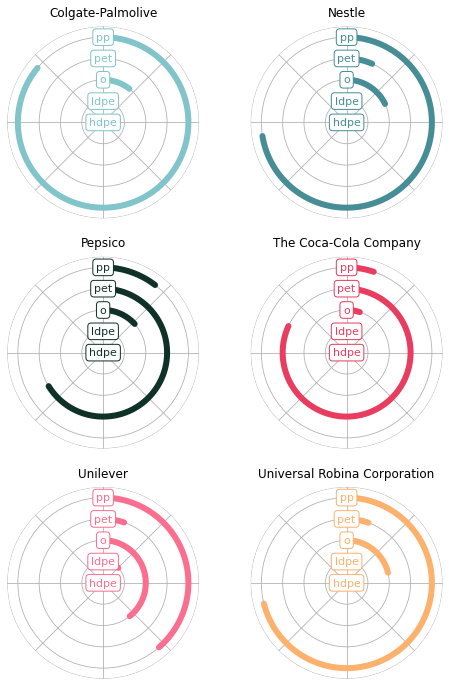

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12), subplot_kw={"projection": "polar"})

axes_flattened = axes.ravel()

for i, company in enumerate(top_seven["company_lumped"].unique()):
    d = top_seven[top_seven["company_lumped"] == company]
    ax = axes_flattened[i]
    
    ax = style_polar_axis(ax)
    
    proportions = d["prop"].values * (2 * np.pi)
    y_pos = np.arange(len(proportions))
    x = np.linspace(0, proportions, num=100)
    y = np.vstack([y_pos] * 100)
    color = COMPANY_PALETTES[i]
    
    ax.plot(x, y, lw=6, color=color, solid_capstyle="round")
    ax.set_title(company, pad=10)
    ax = add_labels_polar_axis(ax, color)

---
For the extra mile section:

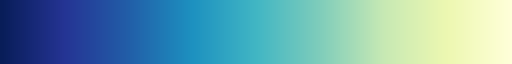

In [13]:
cmap = plt.get_cmap("YlGnBu")
cmap = cmap.reversed()
cmap

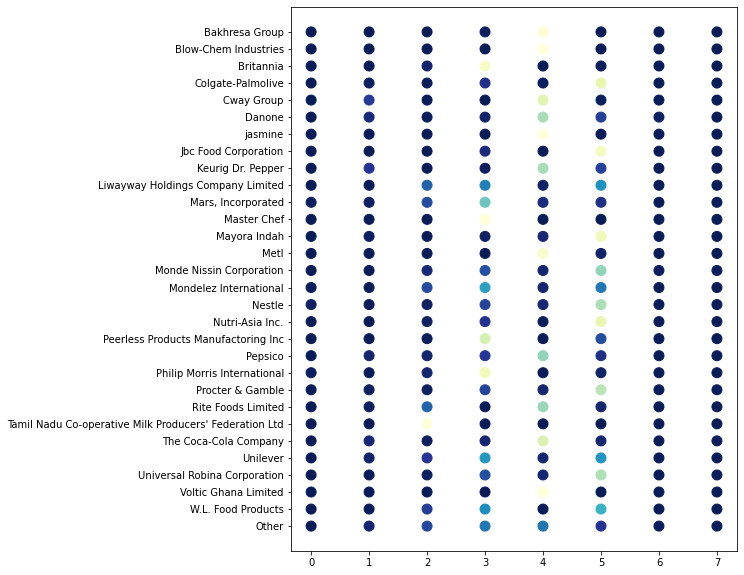

In [14]:
fig, ax = plt.subplots(figsize = (8, 10))

for i, plastic in enumerate(types_of_plastic):
    d = top_thirty[top_thirty["type"] == plastic]
    y = d["company_lumped"]

    # No need to normalize since proportions are between 0 and 1
    colors = cmap(d["proportion"])

    ax.scatter([i] * len(y), d["company_lumped"], color=colors, s=100)